## Creating a function from a symbolic expression
In SymPy there is a function to create a Python function which evaluates (usually numerically) an expression. SymPy allows the user to define the signature of this function (which is convenient when working with e.g. a numerical solver in ``scipy``).

In [1]:
import sympy as sym
sym.init_printing()
x, y = sym.symbols('x y')
expr = 3*x**2 + sym.log(x**2 + y**2 + 1)
expr

One way to evaluate above expression numerically is to invoke the ``subs`` method followed by the ``evalf`` method:

In [2]:
expr.subs({x: 17, y: 42}).evalf()

However, if we need to do this repeatedly it can be quite slow:

In [3]:
%timeit expr.subs({x: 17, y: 42}).evalf()

708 µs ± 59.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


even compared to a simple lambda function:

In [4]:
import math
f = lambda x, y: 3*x**2 + math.log(x**2 + y**2 + 1)
f(17, 42)

In [5]:
%timeit f(17, 42)

2.89 µs ± 42.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


SymPy can also create a function analogous to f above. The function for doing so is called ``lambdify``:

In [6]:
g = sym.lambdify([x, y], expr, modules=['math'])
g(17, 42)

In [7]:
%timeit g(17, 42)

2.77 µs ± 167 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Note how we specified ``modules`` above: it tells ``lambdify`` to use ``math.log``, if we don't specify modules SymPy will (since v1.1) use ``numpy`` by default. This can be useful when dealing with arrays in the input:

In [8]:
import numpy as np
xarr = np.linspace(17, 18, 5)
h = sym.lambdify([x, y], expr)
out = h(xarr, 42)
out.shape

NumPy's broadcasting then works as expected:

In [9]:
yarr = np.linspace(42, 43, 7).reshape((1, 7))
out2 = h(xarr.reshape((5, 1)), yarr)
out2.shape

Behind the scenes ``lambdify`` constructs a string representation of the Python code and uses Python's ``eval`` function to compile the function (to byte-code in CPython).

Let's now look at how we can get a specific function signature from ``lambdify``:

In [10]:
z = z1, z2, z3 = sym.symbols('z:3')
expr2 = x*y*(z1 + z2 + z3)
func2 = sym.lambdify([x, y, z], expr2)
func2(1, 2, (3, 4, 5))

## Case: Radioactive decay
The synthetic isotope Technetium-99m is used in medical diagnostics ([scintigraphy](https://en.wikipedia.org/wiki/Nuclear_medicine)):
$$
^{99m}Tc \overset{\lambda_1}{\longrightarrow} \,^{99}Tc \overset{\lambda_2}{\longrightarrow} \,^{99}Ru \\
\lambda_1 = 3.2\cdot 10^{-5}\,s^{-1} \\
\lambda_2 = 1.04 \cdot 10^{-13}\,s^{-1} \\
$$
SymPy can solve the differential equations describing the amounts versus time analytically.
Let's denote the concentrations of each isotope $x(t),\ y(t)\ \&\ z(t)$ respectively.

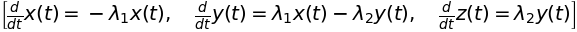

In [11]:
symbs = t, l1, l2, x0, y0, z0 = sym.symbols('t lambda_1 lambda_2 x0 y0 z0', real=True, nonnegative=True)
funcs = x, y, z = [sym.Function(s)(t) for s in 'xyz']
inits = [f.subs(t, 0) for f in funcs]
diffs = [f.diff(t) for f in funcs]
exprs = -l1*x, l1*x - l2*y, l2*y
eqs = [sym.Eq(diff, expr) for diff, expr in zip(diffs, exprs)]
eqs

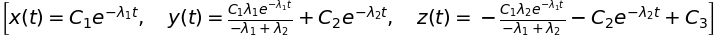

In [12]:
solutions = sym.dsolve(eqs)
solutions

In [13]:
integration_constants = set.union(*[sol.free_symbols for sol in solutions]) - set(symbs)
integration_constants

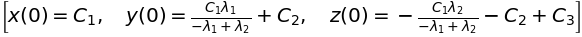

In [14]:
initial_values = [sol.subs(t, 0) for sol in solutions]
initial_values

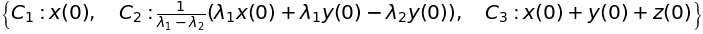

In [15]:
const_exprs = sym.solve(initial_values, integration_constants)
const_exprs

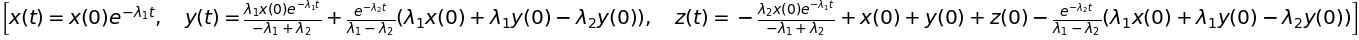

In [16]:
analytic = [sol.subs(const_exprs) for sol in solutions]
analytic

## Exercise: Create a function from a symbolic expression

In [17]:
from math import log10
year_s = 365*24*3600
tout = np.logspace(0, log10(3e6*year_s), 500)  # 1 s to 3 million years

In [18]:
%load_ext scipy2017codegen.exercise

*Use either the *``%exercise``* or *``%load``* magic to get the exercise / solution respectively:*

In [19]:
# %exercise exercise_Tc99.py
f = sym.lambdify([t, l1, l2, *inits], [eq.rhs for eq in analytic])  # EXERCISE: [eq.rhs for eq in analytic]
yout = f(tout, 3.2e-5, 1.04e-13, 1, 0, 0)

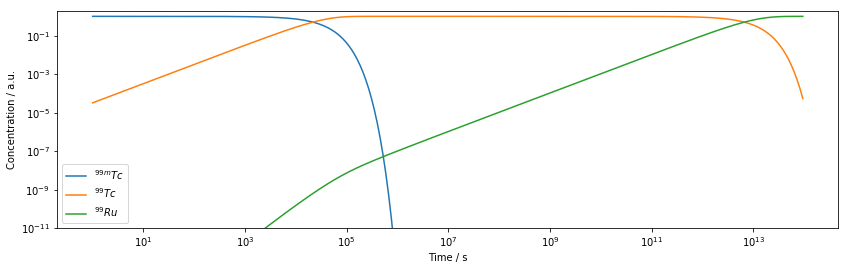

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.loglog(tout.reshape((tout.size, 1)), np.array(yout).T)
ax.legend(['$^{99m}Tc$', '$^{99}Tc$', '$^{99}Ru$'])
ax.set_xlabel('Time / s')
ax.set_ylabel('Concentration / a.u.')
_ = ax.set_ylim([1e-11, 2])